In [2]:
from WirelessSystem.system import *

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import keras

Using TensorFlow backend.


In [5]:
import os
import numpy as np
from SigGAN.train import Trainer

In [6]:
import tensorflow as tf

In [7]:
def norm(sig_u):
    pwr = np.sqrt(np.mean(np.sum(sig_u**2,axis = -1),axis = -1))
    sig_u = sig_u/pwr[:,None,None]
    print(sig_u.shape)
    return sig_u

In [8]:
def shuffle(vec1,vec2,seed = 0):
    np.random.seed(0)
    shfl_indx = np.arange(vec1.shape[0])
    np.random.shuffle(shfl_indx)
    shfl_indx = shfl_indx.astype('int')
    vec1 = vec1[shfl_indx]
    vec2 = np.copy(vec2[shfl_indx])
    return vec1,vec2

In [9]:
def split(vec,n_train,n_valid,n_test):
    vec_train = vec[0:n_train]
    vec_valid = vec[n_train:n_train+n_valid]
    vec_test = vec[n_train+n_valid:]
    return vec_train,vec_valid,vec_test

In [10]:
n_symbols = 256 // 2
n_authorized = 5
n_unauthorized = 5

In [10]:
rf_system = RFSystem(n_authorized = n_authorized, n_unauthorized = n_unauthorized, snr = 0, sess_name = 'test_snr_0')

In [11]:
#rf_system = RFSystem(sess_dir='test_binary_reward_1')

In [12]:
sig_auth_, txid_auth = rf_system.get_n_received_symbol_blocks(5000, n_symbols, authorized = 0)
sig_unauth_, txid_unauth = rf_system.get_n_received_symbol_blocks(5000, n_symbols, authorized = 1)
sig_impersonate_, _ = rf_system.get_n_received_symbol_blocks(10, n_symbols, authorized = 2)

In [13]:
sig_auth=sig_auth_
sig_unauth=sig_unauth_

In [14]:
sig_impersonate_ad_, _ = rf_system.get_n_received_symbol_blocks(5000, n_symbols, authorized = 2)
sig_impersonate_ad=sig_impersonate_ad_

In [15]:
sig_impersonate=sig_impersonate_.reshape((-1,2))

In [16]:
# hyper parameters
B = 64 # batch size
T = 256 # Max length of sentence
g_H = 100 # Generator LSTM hidden size
g_lr = 1e-3
d_dropout = 0.5 # dropout ratio
d_lr = 1e-3

n_sample=1 # Number of Monte Calro Search
generate_samples = 2000 # Number of generated sentences

# Pretraining parameters
g_pre_lr = 1e-3
d_pre_lr = 1e-3
g_pre_epochs= 60
d_pre_epochs = 1

In [39]:
trainer = Trainer(rf_system, B, T, n_authorized, g_H, d_dropout, g_lr=g_lr, d_lr=d_lr, n_sample=n_sample, generate_samples=generate_samples)

In [18]:
sig_rd = np.concatenate([sig_auth,sig_impersonate_ad])
txid_rd = np.concatenate([txid_auth,np.ones((sig_impersonate_ad.shape[0],))*n_authorized])

In [19]:
sig_rd, txid_rd = shuffle(sig_rd, txid_rd)

In [20]:
txid_disc = txid_rd == n_authorized
txid_disc = np.invert(txid_disc)
txid_disc = txid_disc.astype(int)

In [21]:
print(np.unique(txid_disc))
print(np.unique(txid_rd))

[0 1]
[0. 1. 2. 3. 4. 5.]


In [22]:
test_frac = 0.1
valid_frac  = 0.2

n_samples  = sig_rd.shape[0]

n_test = int(test_frac*n_samples)
n_valid = int(valid_frac*n_samples)
n_train = n_samples - n_test - n_valid

In [23]:
sig_rd_train,sig_rd_valid,sig_rd_test=split(sig_rd,n_train,n_valid,n_test)

In [24]:
out_train,out_valid,out_test=split(txid_disc,n_train,n_valid,n_test)

In [25]:
#trainer.load_pre_train_d(rf_system.full_sess_dir)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 2)       0                                            
__________________________________________________________________________________________________
reshape_4 (Reshape)             (None, 256, 2, 1)    0           input_4[0][0]                    
__________________________________________________________________________________________________
1_conv1 (Conv2D)                (None, 256, 2, 16)   32          reshape_4[0][0]                  
__________________________________________________________________________________________________
1_conv2 (Conv2D)                (None, 256, 2, 16)   1552        1_conv1[0][0]                    
__________________________________________________________________________________________________
1_bn (Batc

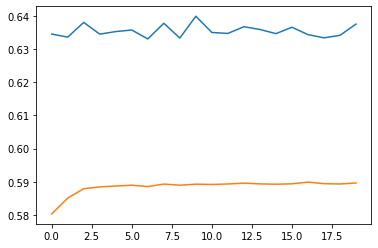

In [67]:
trainer.pre_train_discriminator(d_epochs=20, d_pre_sig_train=sig_rd_train, d_pre_out_train=out_train, d_pre_sig_valid=sig_rd_valid, d_pre_out_valid=out_valid, lr=1e-6)

In [95]:
trainer.save_pre_train_d(rf_system.full_sess_dir)

In [68]:
print(trainer.test_discriminator(sig_rd_train, out_train))

0.7128571428571429


In [69]:
print(trainer.test_discriminator(sig_rd_valid, out_valid))

0.713


In [70]:
print(trainer.test_discriminator(sig_rd_test, out_test))

0.696


In [71]:
print(trainer.test_discriminator(sig_impersonate_ad, np.zeros((sig_impersonate_ad.shape[0],))))

0.8096


In [72]:
np.mean(trainer.predict_discriminator(sig_auth))

0.63539374

In [73]:
np.mean(trainer.predict_discriminator(sig_impersonate_ad))

0.47830585

In [74]:
n_samples_im  = sig_impersonate.shape[0]

n_test_im = int(test_frac*n_samples_im)
n_valid_im = int(valid_frac*n_samples_im)
n_train_im = n_samples_im - n_test_im - n_valid_im

In [75]:
sig_im_train,sig_im_valid,sig_im_test=split(sig_impersonate,n_train_im,n_valid_im,n_test)

In [76]:
sig_im_train_re = sig_im_train.reshape((-1, 1, 2))
sig_im_train_re_t = sig_im_train.reshape((-1, 2))

In [77]:
sig_im_valid_re = sig_im_valid.reshape((-1, 1, 2))
sig_im_valid_re_t = sig_im_valid.reshape((-1, 2))

In [78]:
sig_im_test_re = sig_im_test.reshape((-1, 1,  2))

In [79]:
trainer.pre_train_generator(g_epochs=100, g_pre_data_train=[sig_im_train_re, sig_im_train_re_t], g_pre_data_valid=[sig_im_valid_re, sig_im_valid_re_t], lr=1e-3)

Generator pre-training
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, None, 2)      0                                            
__________________________________________________________________________________________________
LSTM (LSTM)                     (None, 100)          41200       Input[0][0]                      
__________________________________________________________________________________________________
DenseMean (Dense)               (None, 2)            202         LSTM[0][0]                       
__________________________________________________________________________________________________
DenseVariance (Dense)           (None, 2)            202         LSTM[0][0]                       
______________________________________________________________________________________

In [80]:
sig_im_test_re[0]

array([[-0.27360892, -1.2704281 ]], dtype=float32)

In [81]:
print(trainer.predict_pre_generator(sig_im_test_re[:1].reshape(1,1,2)))

[[-0.27072388 -1.2614455 ]]


In [82]:
print(trainer.predict_generator(sig_im_test_re[:1].reshape(1,1,2)))

[[-0.27053845 -1.2613175 ]]


In [83]:
print(trainer.predict_beta_generator(sig_im_test_re[:1].reshape(1,1,2)))

[[-0.28638107 -1.2720116 ]]


In [84]:
print(trainer.predict_curr_discriminator())

0.4502238


In [47]:
g_lr=1e-3
print(g_lr)

0.001


In [92]:
trainer.reset_generator_lr(g_lr)

In [93]:
trainer.reflect_pre_train()

In [94]:
trainer.train(steps=1000)

Initial Disc Accuracy: 0.450
0: Disc Batch Accuracy: 0.150
0, 1: Disc Accuracy: 0.450, Average reward: 1.000
1, 1: Disc Accuracy: 0.580, Average reward: 1.000
2, 1: Disc Accuracy: 0.478, Average reward: 0.000
3, 1: Disc Accuracy: 0.465, Average reward: 1.000
4, 1: Disc Accuracy: 0.670, Average reward: 0.000
5, 1: Disc Accuracy: 0.450, Average reward: 1.000
6, 1: Disc Accuracy: 0.517, Average reward: 0.000
7, 1: Disc Accuracy: 0.506, Average reward: 0.000
8, 1: Disc Accuracy: 0.450, Average reward: 1.000
9, 1: Disc Accuracy: 0.835, Average reward: 0.000
10, 1: Disc Accuracy: 0.452, Average reward: 1.000
11, 1: Disc Accuracy: 0.738, Average reward: 1.000
12, 1: Disc Accuracy: 0.585, Average reward: 1.000
13, 1: Disc Accuracy: 0.558, Average reward: 1.000
14, 1: Disc Accuracy: 0.747, Average reward: 1.000
15, 1: Disc Accuracy: 0.726, Average reward: 1.000
16, 1: Disc Accuracy: 0.773, Average reward: 1.000
17, 1: Disc Accuracy: 0.717, Average reward: 1.000
18, 1: Disc Accuracy: 0.511, Aver

KeyboardInterrupt: 